In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm
import pickle
from scipy import stats
from helper import *

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import *
from sklearn.impute import SimpleImputer
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [10]:
datapath = 'data/original/pre-imputed/'
C1W1nonet_df = pd.read_csv(datapath + 'C1W1_nonnetwork_preimputed.csv')
C1W2nonet_df = pd.read_csv(datapath + 'C1W2_nonnetwork_preimputed.csv')
mappings_df = pd.read_csv(datapath + 'mappings.csv')

C1W1nonet_vars = list(C1W1nonet_df.columns)
C1W2nonet_vars = list(C1W2nonet_df.columns)

C1pred_df = pd.read_csv(datapath + 'C1_nonnetwork_pred.csv')
C2pred_df = pd.read_csv(datapath + 'C2_nonnetwork_pred.csv')

In [3]:
'''
See imputing notes from data_nonet_analysis.ipynb
'''
def impute_MARs(vars, df):

    for v in vars:
        col = df[v]
        if v == 'TB2':
            for idx, i in enumerate(col):
                if i == 5:
                    df.at[idx, 'TB2_4_TEXT'] = -1
                    df.at[idx, 'TB3'] = 1
                    df.at[idx, 'TB4'] = 0
        if v == 'TB3':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB4'] = 0
        if v == 'TB5':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB6'] = -1
                    df.at[idx, 'TB7'] = 1
                    df.at[idx, 'TB8'] = 0
        if v == 'TB7':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB8'] = 0
        if v == 'TB9':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB10'] = -1
                    df.at[idx, 'TB11'] = 1
                    df.at[idx, 'TB12'] = 0
        if v == 'TB11':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'TB12'] = 0
        if v == 'AL1':
            for idx, i in enumerate(col):
                if i == 2:
                    df.at[idx, 'AL1_4_TEXT'] = -1
                    df.at[idx, 'AL2_1_TEXT'] = -1
                    df.at[idx, 'AL3_1_TEXT'] = -1
                    df.at[idx, 'AL4'] = 1
                    df.at[idx, 'AL5'] = 0
                    df.at[idx, 'AL6A'] = 0
                    df.at[idx, 'AL6B'] = 0
                elif i == 3:
                    df.at[idx, 'AL1_4_TEXT'] = -2
        if v == 'AL2':
            for idx, i in enumerate(col):
                if i == 2:
                    df.at[idx, 'AL2_1_TEXT'] = -2
        if v == 'AL3':
            for idx, i in enumerate(col):
                if i == 2:
                    df.at[idx, 'AL3_1_TEXT'] = -2
        if v == 'AL5':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'AL6A'] = 0
                    df.at[idx, 'AL6B'] = 0
        if v == 'AL6A':
            for idx, i in enumerate(col):
                if pd.isnull(df.loc[idx, v]) and not pd.isnull(df.loc[idx, 'AL6B']):
                    df.at[idx, v] = df.at[idx, 'AL6B']
        if v == 'ID1':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'ID2'] = -1
                    for j in range(3,13):
                        df.at[idx, f'ID{j}'] = 0
                    for j in range(15,21):
                        df.at[idx, f'ID{j}'] = -1
        if v == 'ID3':
            for idx, i in enumerate(col):
                if i == 1:
                    for j in range(4,13):
                        df.at[idx, f'ID{j}'] = 0
                    for j in range(15,21):
                        df.at[idx, f'ID{j}'] = -1
        if v == 'ID17':
            for idx, i in enumerate(col):
                if i == 1:
                    for j in range(18,21):
                        df.at[idx, f'ID{j}'] = -1
        if v == 'ND1':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'ND2'] = -1
        if v == 'OD1':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'OD2'] = 0
        if v == 'OD6':
            for idx, i in enumerate(col):
                if i == 2:
                    for j in range(7,12):
                        df.at[idx, f'OD{j}'] = 0
        if v == 'OD8':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'OD9'] = 0
        if v == 'OD10':
            for idx, i in enumerate(col):
                if i == 1:
                    df.at[idx, 'OD11'] = 0
        if v == 'CJ3':
            for idx, i in enumerate(col):
                if i == 1:
                    for j in range(4,8):
                        df.at[idx, f'CJ{j}'] = -1
        if v == 'DM12':
            for idx, i in enumerate(col):
                if i != 1:
                    df.at[idx, 'DM13'] = -1

    vars_mixed = ['DM1','TB2_4_TEXT','TB6','TB10','AL1_4_TEXT','AL2_1_TEXT','AL3_1_TEXT','ID2','ND2']
    for v in vars_mixed:
        col = df[v]
        if v[-4:] == 'TEXT':  # e.g., modify TB2 column instead of TB2_4_TEXT
            v = v.split('_')[0]
        for idx, i in enumerate(col):
            if 0 <= i <= 14:    df.at[idx, v] = 0  # children
            elif 15 <= i <= 24: df.at[idx, v] = 1  # youth
            elif 25 <= i <= 64: df.at[idx, v] = 2  # adult
            elif i >= 65:       df.at[idx, v] = 3  # senior
            elif i == -1:       df.at[idx, v] = -1  # never
            elif i == -2 or (np.isnan(i) and df.at[idx, v] == 4):       df.at[idx, v] = np.nan  # don't know

    v = 'SC1'  # numerical variable (# of years)
    col = df[v]
    for idx, i in enumerate(col):
        if i < 0.5:    df.at[idx, v] = 0  # less than 6 months
        elif 0.5 <= i < 1:  df.at[idx, v] = 1  # 
        elif 1 <= i < 2:    df.at[idx, v] = 2  #
        elif 2 <= i < 5:    df.at[idx, v] = 3  #
        elif 5 <= i < 10:    df.at[idx, v] = 4  #
        elif i >= 10:       df.at[idx, v] = 5  # more than 10 years

    return df

## Static Feature Grouping

### Encode and Impute

After impute_MARs, all variables are categorical (including variables for ages and years)

Note: 'Don't know' responses now will have value NaN instead

In [11]:
df_c1w1 = impute_MARs(C1W1nonet_vars, C1W1nonet_df)
discarded_vars = ['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
            'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df_c1w1.columns) if 'TEXT' in v]
nominal_vars = ['DM8','DM10','DM12','DM13']
indep_vars = list(df_c1w1.drop(columns=discarded_vars).columns)

dep_var_full = []
for a, b in zip(C1pred_df['ND1'], C1pred_df['Q68']):
    if not np.isnan(a) and not np.isnan(b):
        y = 0 if a <= b else 1
        # y = a - b
        dep_var_full.append(y)
    else:   dep_var_full.append(np.nan)

df = pd.concat([df_c1w1, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
X_df = df[df['pred'].notna()].drop(discarded_vars+['pred'], axis=1)
X_ordinal_df = X_df.drop(nominal_vars, axis=1)
X_nominal_df = X_df[nominal_vars]

Apply label encoding for ordinal variables and one-hot encoding for nominal variables

In [12]:
Xenc_ordinal_df = X_ordinal_df.astype('str').apply(LabelEncoder().fit_transform)
Xenc_ordinal_df = Xenc_ordinal_df.where(~X_ordinal_df.isna(), X_ordinal_df)  # Do not encode the NaNs

In [15]:
nominal_cols =[]
for v in nominal_vars:
    nominal_cols.append(pd.get_dummies(X_nominal_df[v], prefix=v))

Xenc_nominal_df = pd.concat(nominal_cols, axis=1)

In [16]:
Xenc_df = pd.concat([Xenc_ordinal_df, Xenc_nominal_df], axis=1)

All variables are categorical, so impute using the most frequent value of corresponding column

In [19]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_imp = imp.fit_transform(Xenc_df)

In [22]:
print(X_imp.shape)
print(f'Any nan left? {np.isnan(X_imp).any()}')

(33, 152)
Any nan left? False


### Grouping Features

In [12]:
f_dict = {}
fgroups = ['SC', 'DM', 'TB', 'AL', 'ID', 'ND', 'DA', 'OD', 'TX', 'AC', 'CJ']  # feature groups
for g in fgroups:
    features = [c for c in Xenc_df if c.startswith(g)]
    f_indices = [Xenc_df.columns.get_loc(c) for c in Xenc_df if c.startswith(g)]  # column indices of the group's features
    f_dict[g] = f_indices
    print(f'{g} ({len(features)}): {features}')

SC (8): ['SC1', 'SC3', 'SC4', 'SC5', 'SC6', 'SC8', 'SC9', 'SC13']
DM (30): ['DM1', 'DM9', 'DM14', 'DM15', 'DM17', 'DM23', 'DM8_1.0', 'DM8_2.0', 'DM8_3.0', 'DM8_4.0', 'DM8_5.0', 'DM8_6.0', 'DM10_1.0', 'DM10_2.0', 'DM10_3.0', 'DM10_4.0', 'DM10_5.0', 'DM10_6.0', 'DM10_7.0', 'DM10_8.0', 'DM10_9.0', 'DM12_1.0', 'DM12_2.0', 'DM12_4.0', 'DM12_5.0', 'DM12_6.0', 'DM13_-1.0', 'DM13_2.0', 'DM13_4.0', 'DM13_5.0']
TB (12): ['TB1', 'TB2', 'TB3', 'TB4', 'TB5', 'TB6', 'TB7', 'TB8', 'TB9', 'TB10', 'TB11', 'TB12']
AL (6): ['AL1', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6A']
ID (18): ['ID1', 'ID2', 'ID3', 'ID4', 'ID5', 'ID6', 'ID7', 'ID8', 'ID9', 'ID10', 'ID11', 'ID12', 'ID15', 'ID16', 'ID17', 'ID18', 'ID19', 'ID20']
ND (12): ['ND1', 'ND2', 'ND3', 'ND4', 'ND5', 'ND6', 'ND7', 'ND8', 'ND9', 'ND10', 'ND11', 'ND12']
DA (14): ['DA1_1', 'DA1_2', 'DA1_3', 'DA1_4', 'DA1_5', 'DA1_6', 'DA1_7', 'DA2_1', 'DA2_2', 'DA2_3', 'DA2_4', 'DA2_5', 'DA2_6', 'DA2_7']
OD (8): ['OD1', 'OD2', 'OD6', 'OD7', 'OD8', 'OD9', 'OD10', 'OD11']
T

Example: access feature group 'AL' directly from X_imp (2D array)

In [ ]:
print(X_imp[:,f_dict['AL']].shape)
X_imp[:,f_dict['AL']]

Example: access list of feature groups ['AL', 'ID'] directly from X_imp (2D array)

In [9]:
fsubsets = ['AL', 'ID']
def get_f_indices(fsubsets):  # concatenate multiple feature groups (lists) into one big list of features
    return [f for fgroup in [f_dict[s] for s in fsubsets] for f in fgroup]

X_imp[:,get_f_indices(fsubsets)][:5]

array([[2., 2., 2., 1., 3., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 2., 1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 2., 3., 1., 6., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 2., 1., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 2., 2., 1., 4., 6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [4]:
fsubs_1, fsubs_2, fsubs_3, fsubs_4 = ['SC'], ['DM'], ['TB','AL','ID','ND','DA','OD'], ['TX','AC','CJ']
fsubs_5 = fsubs_1 + fsubs_2
fsubs_6 = fsubs_1 + fsubs_2 + fsubs_3
fsubs_7 = fsubs_1 + fsubs_2 + fsubs_4
fsubs_8 = fsubs_1 + fsubs_2 + fsubs_3 + fsubs_4
fsubs_nonnet = {'g1': fsubs_1, 'g2': fsubs_2, 'g3': fsubs_3, 'g4': fsubs_4, 'g5': fsubs_5, 'g6': fsubs_6, 'g7': fsubs_7, 'g8': fsubs_8}
# X_imp[:,get_f_indices(fsubsets)]

### Learning Curve

In [33]:
y = np.array(dep_var_full)
y = y[~np.isnan(y)]  # C1, marijuana

In [5]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 10),
    score=None, baseline=1
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    if score is not None:
        axes.plot([], [], ' ', label=f"CV acc/baseline acc: {round(score, 3)}/{round(baseline, 3)}")

    axes.legend(loc="lower right")

    # # Plot n_samples vs fit_times
    # axes[1].grid()
    # axes[1].plot(train_sizes, fit_times_mean, "o-")
    # axes[1].fill_between(
    #     train_sizes,
    #     fit_times_mean - fit_times_std,
    #     fit_times_mean + fit_times_std,
    #     alpha=0.1,
    # )
    # axes[1].set_xlabel("Training examples")
    # axes[1].set_ylabel("fit_times")
    # axes[1].set_title("Scalability of the model")

    # # Plot fit_time vs score
    # fit_time_argsort = fit_times_mean.argsort()
    # fit_time_sorted = fit_times_mean[fit_time_argsort]
    # test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    # test_scores_std_sorted = test_scores_std[fit_time_argsort]
    # axes[2].grid()
    # axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    # axes[2].fill_between(
    #     fit_time_sorted,
    #     test_scores_mean_sorted - test_scores_std_sorted,
    #     test_scores_mean_sorted + test_scores_std_sorted,
    #     alpha=0.1,
    # )
    # axes[2].set_xlabel("fit_times")
    # axes[2].set_ylabel("Score")
    # axes[2].set_title("Performance of the model")

    return plt

Feed the best params found from GridSearchCV into the model's learning curve

In [5]:
@ignore_warnings(category=ConvergenceWarning)
def log_regression_tuned(X, y):
    # param_grid = dict(penalty=['l1', 'l2'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
    # clf = GridSearchCV(estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
    #                     param_grid=param_grid,
    #                     scoring='accuracy',
    #                     cv=LeaveOneOut())
    # clf.fit(standard_scale(X), y)

    # return clf.best_estimator_, clf.best_score_

    clf = LogisticRegression()
    loocv_scores = cross_val_score(clf, standard_scale(X), y, cv=LeaveOneOut())

    return clf, np.mean(loocv_scores)

def pruned_decision_trees_tuned(X, y):
    # param_grid = dict(max_depth=range(2,6), min_samples_split=[5, 10, 15], min_samples_leaf=range(1,6))
    # clf = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
    #                     param_grid=param_grid,
    #                     scoring='accuracy',
    #                     cv=StratifiedKFold())
    clf = DecisionTreeClassifier()
    loocv_scores = cross_val_score(clf, X, y, cv=LeaveOneOut())

    return clf, np.mean(loocv_scores)

def svm_tuned(X, y):
    # param_grid = dict(kernel=['linear','poly','rbf','sigmoid'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
    # clf = GridSearchCV(estimator=SVC(class_weight='balanced'),
    #                     param_grid=param_grid,
    #                     scoring='accuracy',
    #                     cv=StratifiedKFold())
    clf = SVC()
    loocv_scores = cross_val_score(clf, standard_scale(X), y, cv=LeaveOneOut())

    return clf, np.mean(loocv_scores)


def plot_LC_tuned(X, y, cohort, drug, fgroup, savefile=None, baseline=1, n_estimators=3):

    fig, axes = plt.subplots(1, n_estimators, figsize=(15, 5))

    # Cross validation with 50 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

    title = "Learning Curves (logistic regression)"
    estimator, lg_score = log_regression_tuned(X, y)
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[0], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=lg_score, baseline=baseline
    )

    title = "Learning Curves (decision tree)"
    estimator, dt_score = pruned_decision_trees_tuned(X, y)
    plot_learning_curve(
        estimator, title, X, y, axes=axes[1], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=dt_score, baseline=baseline
    )

    title = "Learning Curves (SVM)"
    estimator, svm_score = svm_tuned(X, y)
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[2], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=svm_score, baseline=baseline
    )

    suptitle = f'Cohort {cohort}: {drug} use, features {fgroup}'
    if len(suptitle) > 120:     suptitle = '-\n'.join(suptitle[j:j+120] for j in range(0,len(suptitle), 120))  # break line if title too long
    fig.suptitle(suptitle)
    fig.tight_layout()
    if savefile is None:
        plt.savefig(f'plots/analysis/learning_curve/C{cohort}-{drug}/C{cohort}-{drug}-{fgroup}_learningCurve.pdf', facecolor='white')
    else:
        plt.savefig(savefile, facecolor='white')

    return lg_score, dt_score, svm_score

In [ ]:
drug = 'marijuana'

for gname, fsubs in fsubs_nonnet.items():
    X = X_imp[:,get_f_indices(fsubs)]
    plot_LC_tuned(X, y, drug, gname)

### Extend

In [25]:
datapath = 'data/original/pre-imputed/'

C1W1nonet_df = pd.read_csv(datapath + 'C1W1_nonnetwork_preimputed.csv')
C1pred_df = pd.read_csv(datapath + 'C1_nonnetwork_pred.csv')
C1W1nonet_vars = list(C1W1nonet_df.columns)

C2W1nonet_df = pd.read_csv(datapath + 'C2W1_nonnetwork_preimputed.csv')
C2pred_df = pd.read_csv(datapath + 'C2_nonnetwork_pred.csv')
C2W1nonet_vars = list(C2W1nonet_df.columns)

C1W1nonet_vars == C2W1nonet_vars

True

In [7]:
def get_f_indices(fsubsets):  # concatenate multiple feature groups (lists) into one big list of features
    return [f for fgroup in [f_dict[s] for s in fsubsets] for f in fgroup]

fsubs_1, fsubs_2, fsubs_3, fsubs_4 = ['SC'], ['DM'], ['TB','AL','ID','ND','DA','OD'], ['TX','AC','CJ']
fsubs_5 = fsubs_1 + fsubs_2
fsubs_6 = fsubs_1 + fsubs_2 + fsubs_3
fsubs_7 = fsubs_1 + fsubs_2 + fsubs_4
fsubs_8 = fsubs_1 + fsubs_2 + fsubs_3 + fsubs_4
fsubs_nonnet = {'g1': fsubs_1, 'g2': fsubs_2, 'g3': fsubs_3, 'g4': fsubs_4, 'g5': fsubs_5, 'g6': fsubs_6, 'g7': fsubs_7, 'g8': fsubs_8}

Cohorts 1 and 2 separately

In [ ]:
for cohort in range(1,3):
    for drug in ['marijuana', 'meth']:

        if cohort == 1:
            nonet_vars, nonet_df = C1W1nonet_vars, C1W1nonet_df
            pred_df = C1pred_df
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        elif cohort == 2:
            nonet_vars, nonet_df = C2W1nonet_vars, C2W1nonet_df
            pred_df = C2pred_df
            pred_var = zip(pred_df['ND1'], pred_df['W2_ND1']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['W2_ND7'])

        df = impute_MARs(nonet_vars, nonet_df)
        discarded_vars = ['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                    'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df.columns) if 'TEXT' in v]
        nominal_vars = ['DM8','DM10','DM12','DM13']
        indep_vars = list(df.drop(columns=discarded_vars).columns)
        
        dep_var_full = []
        for a, b in pred_var:
            if not np.isnan(a) and not np.isnan(b):
                y = 0 if a <= b else 1
                # y = a - b
                dep_var_full.append(y)
            else:   dep_var_full.append(np.nan)

        df = pd.concat([df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        X_df = df[df['pred'].notna()].drop(discarded_vars+['pred'], axis=1)
        X_ordinal_df = X_df.drop(nominal_vars, axis=1)
        X_nominal_df = X_df[nominal_vars]

        # Encode
        Xenc_ordinal_df = X_ordinal_df.astype('str').apply(LabelEncoder().fit_transform)
        Xenc_ordinal_df = Xenc_ordinal_df.where(~X_ordinal_df.isna(), X_ordinal_df)  # Do not encode the NaNs

        nominal_cols =[]
        for v in nominal_vars:
            nominal_cols.append(pd.get_dummies(X_nominal_df[v], prefix=v))
        Xenc_nominal_df = pd.concat(nominal_cols, axis=1)

        Xenc_df = pd.concat([Xenc_ordinal_df, Xenc_nominal_df], axis=1)

        # Group features
        f_dict = {}
        fgroups = ['SC', 'DM', 'TB', 'AL', 'ID', 'ND', 'DA', 'OD', 'TX', 'AC', 'CJ']  # feature groups
        for g in fgroups:
            features = [c for c in Xenc_df if c.startswith(g)]
            f_indices = [Xenc_df.columns.get_loc(c) for c in Xenc_df if c.startswith(g)]  # column indices of the group's features
            f_dict[g] = f_indices

        # Impute
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        X_imp = imp.fit_transform(Xenc_df)

        # Learning curve
        y = np.array(dep_var_full)
        y = y[~np.isnan(y)]
        baseline = stats.mode(y)[1][0]/len(y)

        for gname, fsubs in fsubs_nonnet.items():
            X = X_imp[:,get_f_indices(fsubs)]
            plot_LC_tuned(X, y, cohort, drug, gname, baseline=baseline)

Cohorts 1 and 2 combined

In [ ]:
for drug in ['marijuana', 'meth']:

    nonet_df = pd.concat([C1W1nonet_df, C2W1nonet_df], ignore_index=True)
    nonet_vars = C1W1nonet_vars  # same set of columns for both cohorts

    colname_map = {}
    C2pred_keys = list(C2pred_df.columns)
    for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
        colname_map[C2pred_keys[i]] = c

    df_pred = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
    pred_var = zip(df_pred['ND1'], df_pred['Q68']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['Q75'])

    df = impute_MARs(nonet_vars, nonet_df)
    discarded_vars = ['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df.columns) if 'TEXT' in v]
    nominal_vars = ['DM8','DM10','DM12','DM13']
    indep_vars = list(df.drop(columns=discarded_vars).columns)
    
    dep_var_full = []
    for a, b in pred_var:
        if not np.isnan(a) and not np.isnan(b):
            y = 0 if a <= b else 1
            # y = a - b
            dep_var_full.append(y)
        else:   dep_var_full.append(np.nan)

    df = pd.concat([df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
    X_df = df[df['pred'].notna()].drop(discarded_vars+['pred'], axis=1)
    X_ordinal_df = X_df.drop(nominal_vars, axis=1)
    X_nominal_df = X_df[nominal_vars]

    # Encode
    Xenc_ordinal_df = X_ordinal_df.astype('str').apply(LabelEncoder().fit_transform)
    Xenc_ordinal_df = Xenc_ordinal_df.where(~X_ordinal_df.isna(), X_ordinal_df)  # Do not encode the NaNs

    nominal_cols =[]
    for v in nominal_vars:
        nominal_cols.append(pd.get_dummies(X_nominal_df[v], prefix=v))
    Xenc_nominal_df = pd.concat(nominal_cols, axis=1)

    Xenc_df = pd.concat([Xenc_ordinal_df, Xenc_nominal_df], axis=1)

    # Group features
    f_dict = {}
    fgroups = ['SC', 'DM', 'TB', 'AL', 'ID', 'ND', 'DA', 'OD', 'TX', 'AC', 'CJ']  # feature groups
    for g in fgroups:
        features = [c for c in Xenc_df if c.startswith(g)]
        f_indices = [Xenc_df.columns.get_loc(c) for c in Xenc_df if c.startswith(g)]  # column indices of the group's features
        f_dict[g] = f_indices

    # Impute
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    X_imp = imp.fit_transform(Xenc_df)

    # Learning curve
    y = np.array(dep_var_full)
    y = y[~np.isnan(y)]
    baseline = stats.mode(y)[1][0]/len(y)

    for gname, fsubs in fsubs_nonnet.items():
        X = X_imp[:,get_f_indices(fsubs)]
        savefile = f'plots/analysis/learning_curve/C1+2-{drug}/C1+2-{drug}-{gname}_learningCurve.pdf'
        lg_score, dt_score, svm_score = plot_LC_tuned(X, y, cohort='1+2', drug=drug, fgroup=gname, savefile=savefile, baseline=baseline)

## Dynamic Feature Grouping

Iteratively add features into X (sorted by decreasing correlation index) then plot learning curve

In [91]:
%%capture
scores = {}
N_top = 30  # max number of features (with top correlation indices)
for cohort in range(1,3):
    for drug in ['marijuana', 'meth']:

        if cohort == 1:
            nonet_vars, nonet_df = C1W1nonet_vars, C1W1nonet_df
            pred_df = C1pred_df
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        elif cohort == 2:
            nonet_vars, nonet_df = C2W1nonet_vars, C2W1nonet_df
            pred_df = C2pred_df
            pred_var = zip(pred_df['ND1'], pred_df['W2_ND1']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['W2_ND7'])

        df = impute_MARs(nonet_vars, nonet_df)
        discarded_vars = ['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                    'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df.columns) if 'TEXT' in v]
        nominal_vars = ['DM8','DM10','DM12','DM13']
        indep_vars = list(df.drop(columns=discarded_vars).columns)
        
        dep_var_full = []
        for a, b in pred_var:
            if not np.isnan(a) and not np.isnan(b):
                y = 0 if a <= b else 1
                # y = a - b
                dep_var_full.append(y)
            else:   dep_var_full.append(np.nan)

        df = pd.concat([df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        X_df = df[df['pred'].notna()].drop(discarded_vars+['pred'], axis=1)
        X_ordinal_df = X_df.drop(nominal_vars, axis=1)
        X_nominal_df = X_df[nominal_vars]

        # Encode
        Xenc_ordinal_df = X_ordinal_df.astype('str').apply(LabelEncoder().fit_transform)
        Xenc_ordinal_df = Xenc_ordinal_df.where(~X_ordinal_df.isna(), X_ordinal_df)  # Do not encode the NaNs

        nominal_cols =[]
        for v in nominal_vars:
            nominal_cols.append(pd.get_dummies(X_nominal_df[v], prefix=v))
        Xenc_nominal_df = pd.concat(nominal_cols, axis=1)

        Xenc_df = pd.concat([Xenc_ordinal_df, Xenc_nominal_df], axis=1)

        # Impute
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        X_imp = imp.fit_transform(Xenc_df)

        # Load corrs_dict:
        with open(f'saved-vars/C{cohort}-{drug}-nonnet_CramersV.pkl', 'rb') as file:
            corrs_dict = pickle.load(file)
        sorted_corrs_dict = dict(sorted(corrs_dict.items(), key=lambda item: item[1], reverse=True))
        sorted_corrs_list = [v for v in sorted_corrs_dict.keys()]

        # Learning curve
        y = np.array(dep_var_full)
        y = y[~np.isnan(y)]
        baseline = stats.mode(y)[1][0]/len(y)

        train_vars = []
        for i in range(N_top):
            var = sorted_corrs_list[i]
            if var in nominal_vars:
                train_vars.extend([v for v in Xenc_df if v.startswith(var)])
            else:   train_vars.append(var)

            col_indices = sorted([Xenc_df.columns.get_loc(v) for v in train_vars])
            X = X_imp[:,col_indices]
            savefile = f'plots/analysis/learning_curve/C{cohort}-{drug}/C{cohort}-{drug}-top{i+1}_learningCurve.pdf'
            lg_score, dt_score, svm_score = plot_LC_tuned(X, y, cohort, drug, train_vars, savefile=savefile, baseline=baseline)
            scores[f'C{cohort}-{drug}-{i+1}'] = [lg_score, dt_score, svm_score]

with open(f'saved-vars/scores.pkl', 'wb') as file:
    pickle.dump(scores, file)

In [93]:
%%capture
N_top = 30  # max number of features (with top correlation indices)
for drug in ['marijuana', 'meth']:

    nonet_df = pd.concat([C1W1nonet_df, C2W1nonet_df], ignore_index=True)
    nonet_vars = C1W1nonet_vars  # same set of columns for both cohorts

    colname_map = {}
    C2pred_keys = list(C2pred_df.columns)
    for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
        colname_map[C2pred_keys[i]] = c

    df_pred = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
    pred_var = zip(df_pred['ND1'], df_pred['Q68']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['Q75'])

    df = impute_MARs(nonet_vars, nonet_df)
    discarded_vars = ['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df.columns) if 'TEXT' in v]
    nominal_vars = ['DM8','DM10','DM12','DM13']
    indep_vars = list(df.drop(columns=discarded_vars).columns)
    
    dep_var_full = []
    for a, b in pred_var:
        if not np.isnan(a) and not np.isnan(b):
            y = 0 if a <= b else 1
            # y = a - b
            dep_var_full.append(y)
        else:   dep_var_full.append(np.nan)

    df = pd.concat([df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
    X_df = df[df['pred'].notna()].drop(discarded_vars+['pred'], axis=1)
    X_ordinal_df = X_df.drop(nominal_vars, axis=1)
    X_nominal_df = X_df[nominal_vars]

    # Encode
    Xenc_ordinal_df = X_ordinal_df.astype('str').apply(LabelEncoder().fit_transform)
    Xenc_ordinal_df = Xenc_ordinal_df.where(~X_ordinal_df.isna(), X_ordinal_df)  # Do not encode the NaNs

    nominal_cols =[]
    for v in nominal_vars:
        nominal_cols.append(pd.get_dummies(X_nominal_df[v], prefix=v))
    Xenc_nominal_df = pd.concat(nominal_cols, axis=1)

    Xenc_df = pd.concat([Xenc_ordinal_df, Xenc_nominal_df], axis=1)

    # Impute
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    X_imp = imp.fit_transform(Xenc_df)

    # Load corrs_dict:
    with open(f'saved-vars/C12-{drug}-nonnet_CramersV.pkl', 'rb') as file:
        corrs_dict = pickle.load(file)
    sorted_corrs_dict = dict(sorted(corrs_dict.items(), key=lambda item: item[1], reverse=True))
    sorted_corrs_list = [v for v in sorted_corrs_dict.keys()]

    # Learning curve
    y = np.array(dep_var_full)
    y = y[~np.isnan(y)]
    baseline = stats.mode(y)[1][0]/len(y)

    train_vars = []
    for i in range(N_top):
        var = sorted_corrs_list[i]
        if var in nominal_vars:
            train_vars.extend([v for v in Xenc_df if v.startswith(var)])
        else:   train_vars.append(var)

        col_indices = sorted([Xenc_df.columns.get_loc(v) for v in train_vars])
        X = X_imp[:,col_indices]
        savefile = f'plots/analysis/learning_curve/C1+2-{drug}/C1+2-{drug}-top{i+1}_learningCurve.pdf'
        lg_score, dt_score, svm_score = plot_LC_tuned(X, y, cohort='1+2', drug=drug, fgroup=train_vars, savefile=savefile, baseline=baseline)

## Static + Dynamic Grouping

Non-network variables

In [69]:
%%capture
scores = {}
scores_dict = {}
N_top = 30  # max number of features (with top correlation indices)
for cohort in [1, 2, '1+2']:
    for drug in ['marijuana', 'meth']:

        scores_dict[f'{cohort}-{drug}-fgroup'] = []
        scores_dict[f'{cohort}-{drug}-LG'], scores_dict[f'{cohort}-{drug}-DT'], scores_dict[f'{cohort}-{drug}-SVM'] = [], [], []

        if cohort == 1:
            nonet_vars, nonet_df = C1W1nonet_vars, C1W1nonet_df
            pred_df = C1pred_df
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        elif cohort == 2:
            nonet_vars, nonet_df = C2W1nonet_vars, C2W1nonet_df
            pred_df = C2pred_df
            pred_var = zip(pred_df['ND1'], pred_df['W2_ND1']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['W2_ND7'])

        elif cohort == '1+2':
            nonet_df = pd.concat([C1W1nonet_df, C2W1nonet_df], ignore_index=True)
            nonet_vars = C1W1nonet_vars  # same set of columns for both cohorts

            colname_map = {}
            C2pred_keys = list(C2pred_df.columns)
            for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
                colname_map[C2pred_keys[i]] = c

            pred_df = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])

        df = impute_MARs(nonet_vars, nonet_df)
        discarded_vars = ['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                    'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df.columns) if 'TEXT' in v]
        nominal_vars = ['DM8','DM10','DM12','DM13']
        indep_vars = list(df.drop(columns=discarded_vars).columns)
        
        dep_var_full = []
        for a, b in pred_var:
            if not np.isnan(a) and not np.isnan(b):
                y = 0 if a <= b else 1
                # y = a - b
                dep_var_full.append(y)
            else:   dep_var_full.append(np.nan)

        df = pd.concat([df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        X_df = df[df['pred'].notna()].drop(discarded_vars+['pred'], axis=1)
        X_ordinal_df = X_df.drop(nominal_vars, axis=1)
        X_nominal_df = X_df[nominal_vars]

        # Encode
        Xenc_ordinal_df = X_ordinal_df.astype('str').apply(LabelEncoder().fit_transform)
        Xenc_ordinal_df = Xenc_ordinal_df.where(~X_ordinal_df.isna(), X_ordinal_df)  # Do not encode the NaNs

        nominal_cols =[]
        for v in nominal_vars:
            nominal_cols.append(pd.get_dummies(X_nominal_df[v], prefix=v))
        Xenc_nominal_df = pd.concat(nominal_cols, axis=1)

        Xenc_df = pd.concat([Xenc_ordinal_df, Xenc_nominal_df], axis=1)

        # Group features
        f_dict = {}
        fgroups = ['SC', 'DM', 'TB', 'AL', 'ID', 'ND', 'DA', 'OD', 'TX', 'AC', 'CJ']  # feature groups
        for g in fgroups:
            features = [c for c in Xenc_df if c.startswith(g)]
            f_indices = [Xenc_df.columns.get_loc(c) for c in Xenc_df if c.startswith(g)]  # column indices of the group's features
            f_dict[g] = f_indices

        # Impute
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        X_imp = imp.fit_transform(Xenc_df)

        # Load corrs_dict:
        with open(f"saved-vars/C{''.join(str(cohort).split('+'))}-{drug}-nonnet_CramersV.pkl", 'rb') as file:
            corrs_dict = pickle.load(file)
        corrs_dict = {k: v for k, v in corrs_dict.items() if not np.isnan(v)}  # sort dict by value won't work properly if there is a key w/ nan value
        sorted_corrs_dict = dict(sorted(corrs_dict.items(), key=lambda item: item[1], reverse=True))
        sorted_corrs_list = [v for v in sorted_corrs_dict.keys()]

        # Learning curve
        y = np.array(dep_var_full)
        y = y[~np.isnan(y)]
        baseline = stats.mode(y)[1][0]/len(y)

        # Static grouping
        for gname, fsubs in fsubs_nonnet.items():
            X = X_imp[:, [f for fgroup in [f_dict[s] for s in fsubs] for f in fgroup]]
            lg_score, dt_score, svm_score = plot_LC_tuned(X, y, cohort, drug, gname, baseline=baseline)
            scores_dict[f'{cohort}-{drug}-fgroup'].append(gname)
            scores_dict[f'{cohort}-{drug}-LG'].append(lg_score)
            scores_dict[f'{cohort}-{drug}-DT'].append(dt_score)
            scores_dict[f'{cohort}-{drug}-SVM'].append(svm_score)

        # Dynamic grouping
        train_vars = []
        for i in range(N_top):
            var = sorted_corrs_list[i]
            if var in nominal_vars:
                train_vars.extend([v for v in Xenc_df if v.startswith(var)])
            else:   train_vars.append(var)

            col_indices = sorted([Xenc_df.columns.get_loc(v) for v in train_vars])
            X = X_imp[:,col_indices]
            savefile = f'plots/analysis/learning_curve/C{cohort}-{drug}/C{cohort}-{drug}-top{i+1}_learningCurve.pdf'
            lg_score, dt_score, svm_score = plot_LC_tuned(X, y, cohort, drug, train_vars, savefile=savefile, baseline=baseline)
            scores_dict[f'{cohort}-{drug}-fgroup'].append(sorted_corrs_list[:i+1])
            scores_dict[f'{cohort}-{drug}-LG'].append(lg_score)
            scores_dict[f'{cohort}-{drug}-DT'].append(dt_score)
            scores_dict[f'{cohort}-{drug}-SVM'].append(svm_score)

        scores_dict[f'{cohort}-{drug}-baseline'] = [baseline] * (len(fsubs_nonnet)+N_top)

pd.DataFrame.from_dict(scores_dict).to_csv('results/scores_nonnetwork.csv', index=False)

Network variables

In [7]:
fsubs_net = {'g9': ['NSX'], 'g10': ['NDX'], 'g11': ['NSX','NDX']}

In [9]:
%%capture
scores = {}
scores_dict = {}
N_top = 30  # max number of features (with top correlation indices)
for cohort in [1, 2, '1+2']:
    for drug in ['marijuana', 'meth']:

        scores_dict[f'{cohort}-{drug}-fgroup'] = []
        scores_dict[f'{cohort}-{drug}-LG'], scores_dict[f'{cohort}-{drug}-DT'], scores_dict[f'{cohort}-{drug}-SVM'] = [], [], []

        # csv generated from data_net_analysis.ipynb (Cramer's V section)
        df = pd.read_csv(f"saved-vars/C{''.join(str(cohort).split('+'))}_network-processed.csv")
        if cohort == 1:
            pred_df = C1pred_df
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        elif cohort == 2:
            pred_df = C2pred_df
            pred_var = zip(pred_df['ND1'], pred_df['W2_ND1']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['W2_ND7'])

        elif cohort == '1+2':
            colname_map = {}
            C2pred_keys = list(C2pred_df.columns)
            for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
                colname_map[C2pred_keys[i]] = c

            pred_df = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        
        dep_var_full = []
        for a, b in pred_var:
            if not np.isnan(a) and not np.isnan(b):
                y = 0 if a <= b else 1
                # y = a - b
                dep_var_full.append(y)
            else:   dep_var_full.append(np.nan)

        df = pd.concat([df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        X_df = df[df['pred'].notna()].drop('pred', axis=1)

        # Group features
        f_dict = {}
        fgroups = ['NSX','NDX']  # feature groups
        for g in fgroups:
            features = [c for c in X_df if c.startswith(g) or g[:2] in c]
            f_indices = [X_df.columns.get_loc(c) for c in X_df if c.startswith(g)]  # column indices of the group's features
            f_dict[g] = f_indices

        X_np = X_df.to_numpy()

        # Load corrs_dict:
        with open(f"saved-vars/C{''.join(str(cohort).split('+'))}-{drug}-net_CramersV.pkl", 'rb') as file:
            corrs_dict = pickle.load(file)
        corrs_dict = {k: v for k, v in corrs_dict.items() if not np.isnan(v)}  # sort dict by value won't work properly if there is a key w/ nan value
        sorted_corrs_dict = dict(sorted(corrs_dict.items(), key=lambda item: item[1], reverse=True))
        sorted_corrs_list = [v for v in sorted_corrs_dict.keys()]

        # Learning curve
        y = np.array(dep_var_full)
        y = y[~np.isnan(y)]
        baseline = stats.mode(y)[1][0]/len(y)

        # Static grouping
        for gname, fsubs in fsubs_net.items():
            X = X_np[:, [f for fgroup in [f_dict[s] for s in fsubs] for f in fgroup]]
            savefile = f'plots/analysis/learning_curve/net/C{cohort}-{drug}/C{cohort}-{drug}-{gname}_learningCurve.pdf'
            lg_score, dt_score, svm_score = plot_LC_tuned(X, y, cohort, drug, gname, savefile=savefile, baseline=baseline)
            scores_dict[f'{cohort}-{drug}-fgroup'].append(gname)
            scores_dict[f'{cohort}-{drug}-LG'].append(lg_score)
            scores_dict[f'{cohort}-{drug}-DT'].append(dt_score)
            scores_dict[f'{cohort}-{drug}-SVM'].append(svm_score)

        # Dynamic grouping
        train_vars = []
        for i in range(N_top):
            var = sorted_corrs_list[i]
            train_vars.append(var)

            col_indices = sorted([X_df.columns.get_loc(v) for v in train_vars])
            X = X_np[:,col_indices]
            savefile = f'plots/analysis/learning_curve/net/C{cohort}-{drug}/C{cohort}-{drug}-top{i+1}_learningCurve.pdf'
            lg_score, dt_score, svm_score = plot_LC_tuned(X, y, cohort, drug, train_vars, savefile=savefile, baseline=baseline)
            scores_dict[f'{cohort}-{drug}-fgroup'].append(sorted_corrs_list[:i+1])
            scores_dict[f'{cohort}-{drug}-LG'].append(lg_score)
            scores_dict[f'{cohort}-{drug}-DT'].append(dt_score)
            scores_dict[f'{cohort}-{drug}-SVM'].append(svm_score)

        scores_dict[f'{cohort}-{drug}-baseline'] = [baseline] * (len(fsubs_net)+N_top)

pd.DataFrame.from_dict(scores_dict).to_csv('results/scores_network.csv', index=False)

Non-network + network variables

In [8]:
fsubs_netnonnet = { 'g12': fsubs_nonnet['g3']+fsubs_net['g10'],
                    'g13': fsubs_nonnet['g6']+fsubs_net['g10'],
                    'g14': fsubs_nonnet['g8']+fsubs_net['g11']}

In [11]:
%%capture
scores = {}
scores_dict = {}
N_top = 30  # max number of features (with top correlation indices)
for cohort in [1, 2, '1+2']:
    for drug in ['marijuana', 'meth']:

        scores_dict[f'{cohort}-{drug}-fgroup'] = []
        scores_dict[f'{cohort}-{drug}-LG'], scores_dict[f'{cohort}-{drug}-DT'], scores_dict[f'{cohort}-{drug}-SVM'] = [], [], []

        net_df = pd.read_csv(f"saved-vars/C{''.join(str(cohort).split('+'))}_network-processed.csv")
        if cohort == 1:
            nonet_vars, nonet_df = C1W1nonet_vars, C1W1nonet_df
            pred_df = C1pred_df
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        elif cohort == 2:
            nonet_vars, nonet_df = C2W1nonet_vars, C2W1nonet_df
            pred_df = C2pred_df
            pred_var = zip(pred_df['ND1'], pred_df['W2_ND1']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['W2_ND7'])

        elif cohort == '1+2':
            nonet_df = pd.concat([C1W1nonet_df, C2W1nonet_df], ignore_index=True)
            nonet_vars = C1W1nonet_vars  # same set of columns for both cohorts

            colname_map = {}
            C2pred_keys = list(C2pred_df.columns)
            for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
                colname_map[C2pred_keys[i]] = c

            pred_df = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])

        nonet_df = impute_MARs(nonet_vars, nonet_df)
        discarded_vars = ['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                    'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(nonet_df.columns) if 'TEXT' in v]
        nominal_vars = ['DM8','DM10','DM12','DM13']
        
        dep_var_full = []
        for a, b in pred_var:
            if not np.isnan(a) and not np.isnan(b):
                y = 0 if a <= b else 1
                # y = a - b
                dep_var_full.append(y)
            else:   dep_var_full.append(np.nan)

        #---------------------------------- Non-network ------------------------------------------------------
        nonet_df = pd.concat([nonet_df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        Xnonet_df = nonet_df[nonet_df['pred'].notna()].drop(discarded_vars+['pred'], axis=1)
        X_ordinal_df = Xnonet_df.drop(nominal_vars, axis=1)
        X_nominal_df = Xnonet_df[nominal_vars]

        # Encode
        Xenc_ordinal_df = X_ordinal_df.astype('str').apply(LabelEncoder().fit_transform)
        Xenc_ordinal_df = Xenc_ordinal_df.where(~X_ordinal_df.isna(), X_ordinal_df)  # Do not encode the NaNs

        nominal_cols =[]
        for v in nominal_vars:
            nominal_cols.append(pd.get_dummies(X_nominal_df[v], prefix=v))
        Xenc_nominal_df = pd.concat(nominal_cols, axis=1)

        Xenc_df = pd.concat([Xenc_ordinal_df, Xenc_nominal_df], axis=1)

        # Group non-network features
        f_nonet_dict = {}
        fgroups_nonet = ['SC', 'DM', 'TB', 'AL', 'ID', 'ND', 'DA', 'OD', 'TX', 'AC', 'CJ']  # feature groups
        for g in fgroups_nonet:
            features = [c for c in Xenc_df if c.startswith(g)]
            f_indices = [Xenc_df.columns.get_loc(c) for c in Xenc_df if c.startswith(g)]  # column indices of the group's features
            f_nonet_dict[g] = f_indices

        # Impute
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        X_imp = imp.fit_transform(Xenc_df)

        # Load corrs_dict (non-network):
        with open(f"saved-vars/C{''.join(str(cohort).split('+'))}-{drug}-nonnet_CramersV.pkl", 'rb') as file:
            corrs_nonet_dict = pickle.load(file)
        corrs_nonet_dict = {k: v for k, v in corrs_nonet_dict.items() if not np.isnan(v)}  # sort dict by value won't work properly if there is a key w/ nan value

        #---------------------------------- Network ------------------------------------------------------
        net_df = pd.concat([net_df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        Xnet_df = net_df[net_df['pred'].notna()].drop('pred', axis=1)

        # Group network features
        f_net_dict = {}
        fgroups_net = ['NSX','NDX']  # feature groups
        for g in fgroups_net:
            features = [c for c in Xnet_df if c.startswith(g) or g[:2] in c]
            f_indices = [Xnet_df.columns.get_loc(c) for c in Xnet_df if c.startswith(g)]  # column indices of the group's features
            f_net_dict[g] = f_indices

        X_np = Xnet_df.to_numpy()

        # Load corrs_dict (network):
        with open(f"saved-vars/C{''.join(str(cohort).split('+'))}-{drug}-net_CramersV.pkl", 'rb') as file:
            corrs_net_dict = pickle.load(file)
        corrs_net_dict = {k: v for k, v in corrs_net_dict.items() if not np.isnan(v)}  # sort dict by value won't work properly if there is a key w/ nan value
        #-------------------------------------------------------------------------------------------

        corrs_dict = corrs_nonet_dict | corrs_net_dict
        sorted_corrs_dict = dict(sorted(corrs_dict.items(), key=lambda item: item[1], reverse=True))
        sorted_corrs_list = [v for v in sorted_corrs_dict.keys()]

        # Learning curve
        y = np.array(dep_var_full)
        y = y[~np.isnan(y)]
        baseline = stats.mode(y)[1][0]/len(y)

        # Static grouping
        for gname, fsubs in fsubs_netnonnet.items():
            X_nonet = X_imp[:, [f for fgroup in [f_nonet_dict[s] for s in fsubs if s in fgroups_nonet] for f in fgroup]]
            X_net = X_np[:, [f for fgroup in [f_net_dict[s] for s in fsubs if s in fgroups_net] for f in fgroup]]
            X = np.concatenate((X_nonet, X_net), axis=1)
            savefile = f'plots/analysis/learning_curve/nonnet+net/C{cohort}-{drug}/C{cohort}-{drug}-{gname}_learningCurve.pdf'
            lg_score, dt_score, svm_score = plot_LC_tuned(X, y, cohort, drug, gname, savefile=savefile, baseline=baseline)
            scores_dict[f'{cohort}-{drug}-fgroup'].append(gname)
            scores_dict[f'{cohort}-{drug}-LG'].append(lg_score)
            scores_dict[f'{cohort}-{drug}-DT'].append(dt_score)
            scores_dict[f'{cohort}-{drug}-SVM'].append(svm_score)

        # Dynamic grouping
        train_vars = []
        for i in range(N_top):
            var = sorted_corrs_list[i]
            if var in nominal_vars:
                train_vars.extend([v for v in Xenc_df if v.startswith(var)])
            else:   train_vars.append(var)

            col_indices_nonet = sorted([Xenc_df.columns.get_loc(v) for v in train_vars if v in list(Xenc_df.columns)])
            col_indices_net = sorted([Xnet_df.columns.get_loc(v) for v in train_vars if v in list(Xnet_df.columns)])
            X = np.concatenate((X_imp[:,col_indices_nonet], X_np[:,col_indices_net]), axis=1)
            savefile = f'plots/analysis/learning_curve/nonnet+net/C{cohort}-{drug}/C{cohort}-{drug}-top{i+1}_learningCurve.pdf'
            lg_score, dt_score, svm_score = plot_LC_tuned(X, y, cohort, drug, train_vars, savefile=savefile, baseline=baseline)
            scores_dict[f'{cohort}-{drug}-fgroup'].append(sorted_corrs_list[:i+1])
            scores_dict[f'{cohort}-{drug}-LG'].append(lg_score)
            scores_dict[f'{cohort}-{drug}-DT'].append(dt_score)
            scores_dict[f'{cohort}-{drug}-SVM'].append(svm_score)

        scores_dict[f'{cohort}-{drug}-baseline'] = [baseline] * (len(fsubs_netnonnet)+N_top)

pd.DataFrame.from_dict(scores_dict).to_csv('results/scores_nonnetwork+network.csv', index=False)

## Sandbox

In [12]:
@ignore_warnings(category=ConvergenceWarning)
def log_regression_tuned(X, y):
    param_grid = dict(penalty=['l1', 'l2'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
    clf = GridSearchCV(estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=LeaveOneOut())
    clf.fit(standard_scale(X), y)

    return clf.best_estimator_, clf.best_score_

    # clf = LogisticRegression()
    # loocv_scores = cross_val_score(clf, standard_scale(X), y, cv=LeaveOneOut())

    # return clf, np.mean(loocv_scores)

def pruned_decision_trees_tuned(X, y):
    # param_grid = dict(max_depth=range(2,6), min_samples_split=[5, 10, 15], min_samples_leaf=range(1,6))
    # clf = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
    #                     param_grid=param_grid,
    #                     scoring='accuracy',
    #                     cv=StratifiedKFold())
    clf = DecisionTreeClassifier()
    loocv_scores = cross_val_score(clf, X, y, cv=LeaveOneOut())

    return clf, np.mean(loocv_scores)

def svm_tuned(X, y):
    # param_grid = dict(kernel=['linear','poly','rbf','sigmoid'], C=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
    # clf = GridSearchCV(estimator=SVC(class_weight='balanced'),
    #                     param_grid=param_grid,
    #                     scoring='accuracy',
    #                     cv=StratifiedKFold())
    clf = SVC()
    loocv_scores = cross_val_score(clf, standard_scale(X), y, cv=LeaveOneOut())

    return clf, np.mean(loocv_scores)


def plot_LC_tuned(X, y, cohort, drug, fgroup, savefile=None, baseline=1, n_estimators=3):

    fig, axes = plt.subplots(1, n_estimators, figsize=(15, 5))

    # Cross validation with 50 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=50, test_size=0.1, random_state=0)
    # cv = LeaveOneOut()

    title = "Learning Curves (logistic regression)"
    estimator, lg_score = log_regression_tuned(X, y)
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[0], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=lg_score, baseline=baseline
    )

    title = "Learning Curves (decision tree)"
    estimator, dt_score = pruned_decision_trees_tuned(X, y)
    plot_learning_curve(
        estimator, title, X, y, axes=axes[1], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=dt_score, baseline=baseline
    )

    title = "Learning Curves (SVM)"
    estimator, svm_score = svm_tuned(X, y)
    plot_learning_curve(
        estimator, title, standard_scale(X), y, axes=axes[2], ylim=(0.1, 1.01), cv=cv, n_jobs=4, scoring="accuracy", score=svm_score, baseline=baseline
    )

    suptitle = f'Cohort {cohort}: {drug} use, features {fgroup}'
    if len(suptitle) > 120:     suptitle = '-\n'.join(suptitle[j:j+120] for j in range(0,len(suptitle), 120))  # break line if title too long
    fig.suptitle(suptitle)
    fig.tight_layout()
    # if savefile is None:
    #     plt.savefig(f'plots/analysis/learning_curve/C{cohort}-{drug}/C{cohort}-{drug}-{fgroup}_learningCurve.pdf', facecolor='white')
    # else:
    #     plt.savefig(savefile, facecolor='white')

    return lg_score, dt_score, svm_score

efef

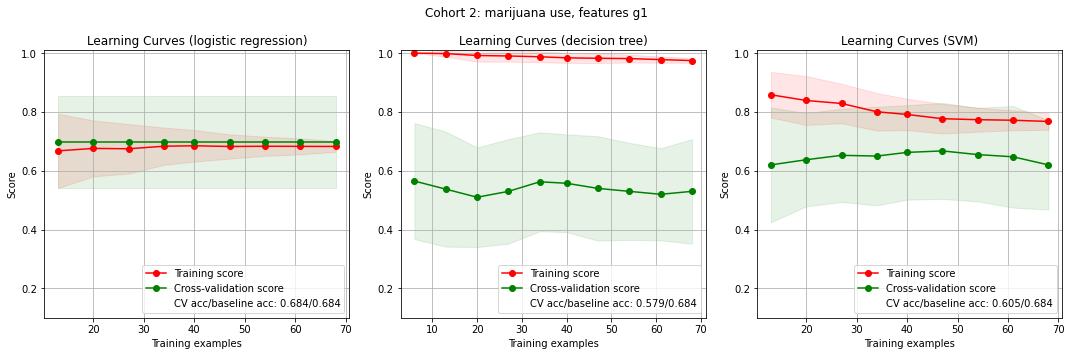

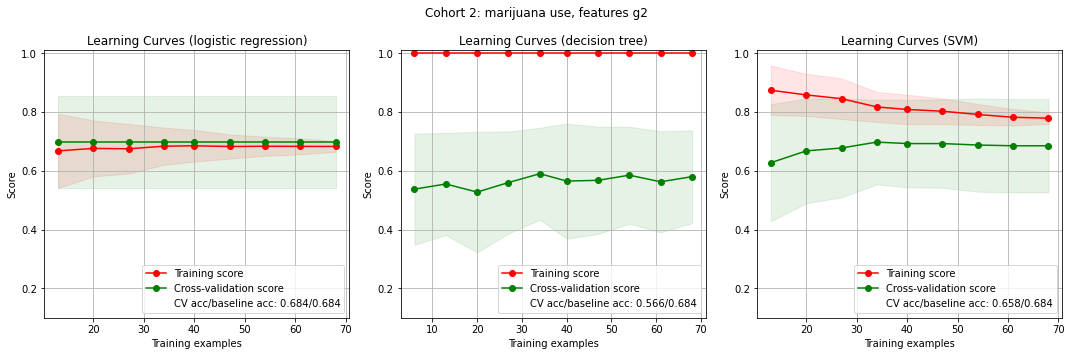

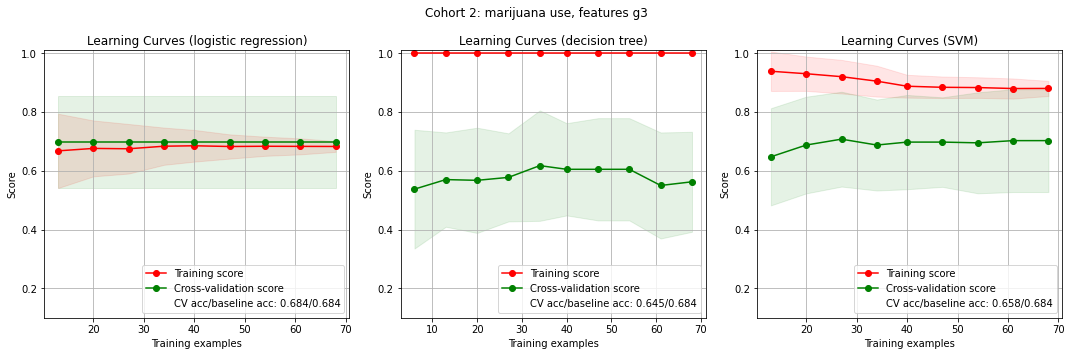

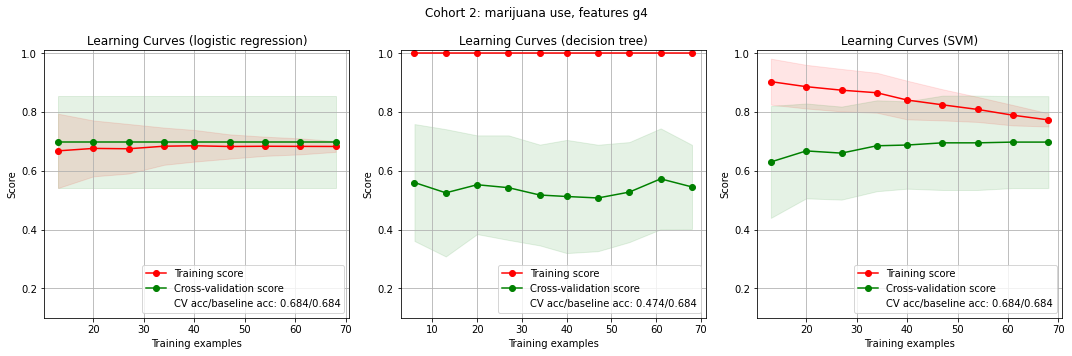

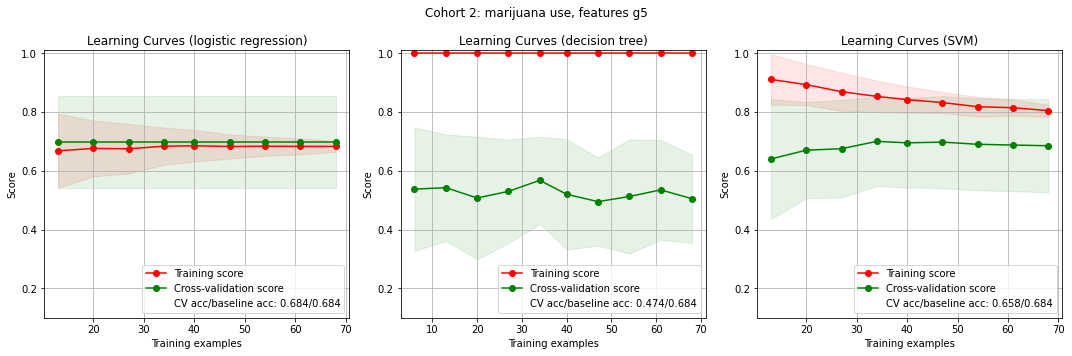

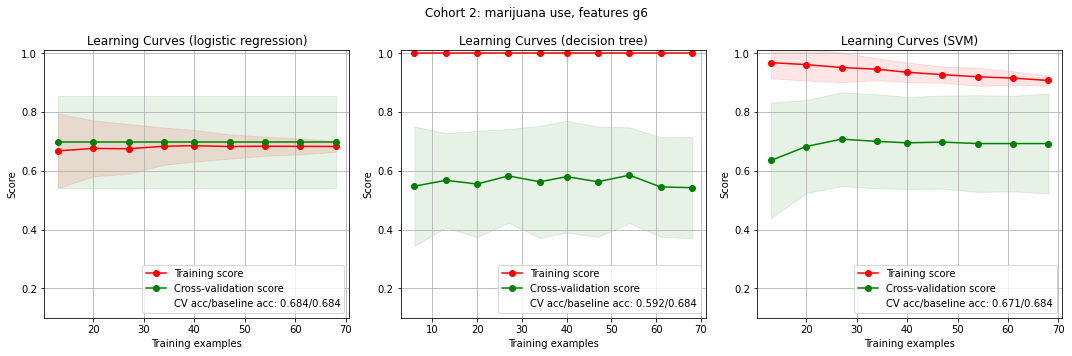

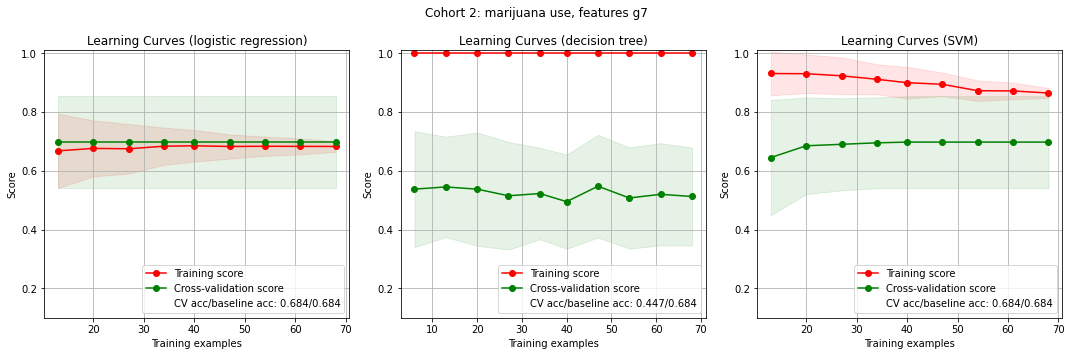

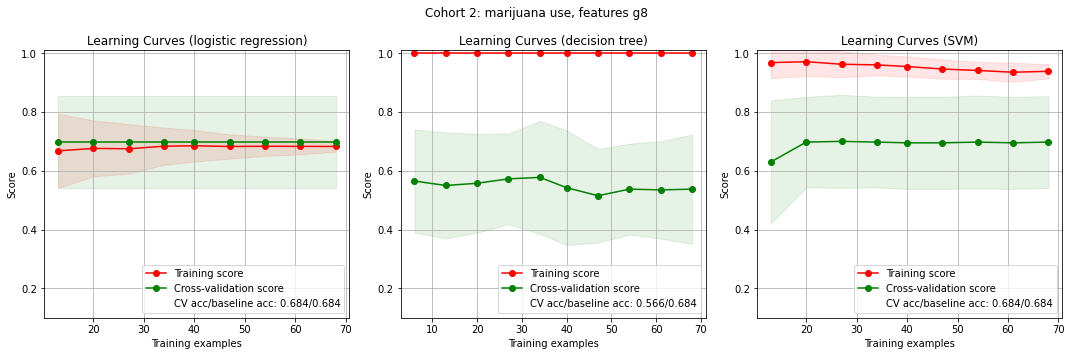

In [16]:
for cohort in [2]:
    for drug in ['marijuana']:

        if cohort == 1:
            nonet_vars, nonet_df = C1W1nonet_vars, C1W1nonet_df
            pred_df = C1pred_df
            pred_var = zip(pred_df['ND1'], pred_df['Q68']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['Q75'])
        elif cohort == 2:
            nonet_vars, nonet_df = C2W1nonet_vars, C2W1nonet_df
            pred_df = C2pred_df
            pred_var = zip(pred_df['ND1'], pred_df['W2_ND1']) if drug == 'marijuana' else zip(pred_df['ND7'], pred_df['W2_ND7'])

        df = impute_MARs(nonet_vars, nonet_df)
        discarded_vars = ['PID','PID2','AL6B','ID13','ID14_4','ID14_5','ID14_6','ID14_7','ND13','ND15_4','ND15_5','ND15_6','ND15_7',
                    'DA5','DA6','DA7','DA7a','DA7b','DA7c','DA7d','DA8','DA8a','DA8b','DA8c','DA8d'] + [v for v in list(df.columns) if 'TEXT' in v]
        nominal_vars = ['DM8','DM10','DM12','DM13']
        indep_vars = list(df.drop(columns=discarded_vars).columns)
        
        dep_var_full = []
        for a, b in pred_var:
            if not np.isnan(a) and not np.isnan(b):
                y = 0 if a <= b else 1
                # y = a - b
                dep_var_full.append(y)
            else:   dep_var_full.append(np.nan)

        df = pd.concat([df, pd.DataFrame({'pred': dep_var_full})], axis=1)  # drop rows where prediction var is missing
        X_df = df[df['pred'].notna()].drop(discarded_vars+['pred'], axis=1)
        X_ordinal_df = X_df.drop(nominal_vars, axis=1)
        X_nominal_df = X_df[nominal_vars]

        # Encode
        Xenc_ordinal_df = X_ordinal_df.astype('str').apply(LabelEncoder().fit_transform)
        Xenc_ordinal_df = Xenc_ordinal_df.where(~X_ordinal_df.isna(), X_ordinal_df)  # Do not encode the NaNs

        nominal_cols =[]
        for v in nominal_vars:
            nominal_cols.append(pd.get_dummies(X_nominal_df[v], prefix=v))
        Xenc_nominal_df = pd.concat(nominal_cols, axis=1)

        Xenc_df = pd.concat([Xenc_ordinal_df, Xenc_nominal_df], axis=1)

        # Group features
        f_dict = {}
        fgroups = ['SC', 'DM', 'TB', 'AL', 'ID', 'ND', 'DA', 'OD', 'TX', 'AC', 'CJ']  # feature groups
        for g in fgroups:
            features = [c for c in Xenc_df if c.startswith(g)]
            f_indices = [Xenc_df.columns.get_loc(c) for c in Xenc_df if c.startswith(g)]  # column indices of the group's features
            f_dict[g] = f_indices

        # Impute
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        X_imp = imp.fit_transform(Xenc_df)

        # Learning curve
        y = np.array(dep_var_full)
        y = y[~np.isnan(y)]
        baseline = stats.mode(y)[1][0]/len(y)

        for gname, fsubs in fsubs_nonnet.items():
            X = X_imp[:,get_f_indices(fsubs)]
            plot_LC_tuned(X, y, cohort, drug, gname, baseline=baseline)